In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob

In [3]:
"""
Consider the "fooling yourself" approach
"""
import os
import numpy as np
import tensorflow as tf
import tensorbayes as tb
from config import args
from tensorbayes.layers import *
from models import *
from utils import plot_results, load_model, save_model
from pprint import pprint
from data import CelebA

Namespace(adj=0.0, bs=16, data='/local-scratch/rshu15/nerdd/training-64x64.mat', e_size=128, f_size=64, gamma=0.5, i_size=64, k=0.0, lambd=0.001, log_step=100, lr=0.0001, lr_step=100000, max_iter=500000, plot_step=2000, run=999, save='/scratch/users/rshu15/nerdd/', save_step=20000)


In [4]:
celeba = CelebA(args.data)

Preparing file


In [5]:
tf.reset_default_graph()
x_real = placeholder((None, args.i_size, args.i_size, 1), name='x')
z = placeholder((None, args.e_size), name='z')
k = placeholder(None, name='k')
lr = placeholder(None, name='lr')
gamma = placeholder(None, name='g')

# Generate
x_fake = decoder(z, 'g_dec')
z_real = encoder(x_real, 'g_enc')

# discriminate
z_real2 = encoder(x_real, 'd_enc')
x_real2 = decoder(z, 'd_dec')

In [6]:
# Saver
sess = tf.Session()
load_model(sess)
saver = tf.train.Saver(max_to_keep=5)

In [7]:
f_gen = tb.function(sess, [z], x_fake)
f_enc = tb.function(sess, [x_real], z_real)

f_enc2 = tb.function(sess, [x_real], z_real2)
f_dec2 = tb.function(sess, [z], x_real2)

In [8]:
def draw(z, r, c, f_gen=f_gen, celeba=celeba):
    img = f_gen(z)
    img = img.reshape(r, c, 64, 64).swapaxes(1, 2).reshape(r * 64, c * 64)
    img = celeba.denorm(img)
    return img

def reshape(img, r, c):
    img = img.reshape(r, c, 64, 64).swapaxes(1, 2).reshape(r * 64, c * 64)
    img = celeba.denorm(img)
    return img

In [9]:
list(np.sort(glob('/scratch/users/rshu15/nerdd/results/*')))

['/scratch/users/rshu15/nerdd/results/gamma=0.2_run=2',
 '/scratch/users/rshu15/nerdd/results/gamma=0.3_run=1',
 '/scratch/users/rshu15/nerdd/results/gamma=0.4_run=0',
 '/scratch/users/rshu15/nerdd/results/gamma=0.5_run=0',
 '/scratch/users/rshu15/nerdd/results/gamma=0.5_run=1',
 '/scratch/users/rshu15/nerdd/results/gamma=0.6_run=0',
 '/scratch/users/rshu15/nerdd/results/gamma=0.6_run=3',
 '/scratch/users/rshu15/nerdd/results/gamma=0.7_run=4',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=1',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=5']

In [10]:
list(np.sort(glob('/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/*.ckpt.index')))

['/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=100000.ckpt.index',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=20000.ckpt.index',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=40000.ckpt.index',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=60000.ckpt.index',
 '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=80000.ckpt.index']

In [20]:
saver.restore(sess, '/scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=80000.ckpt')

INFO:tensorflow:Restoring parameters from /scratch/users/rshu15/nerdd/results/gamma=0.8_run=2/model_iter=80000.ckpt


# Real Images

In [16]:
img = celeba.x[:225]
img = reshape(img, 15, 15)

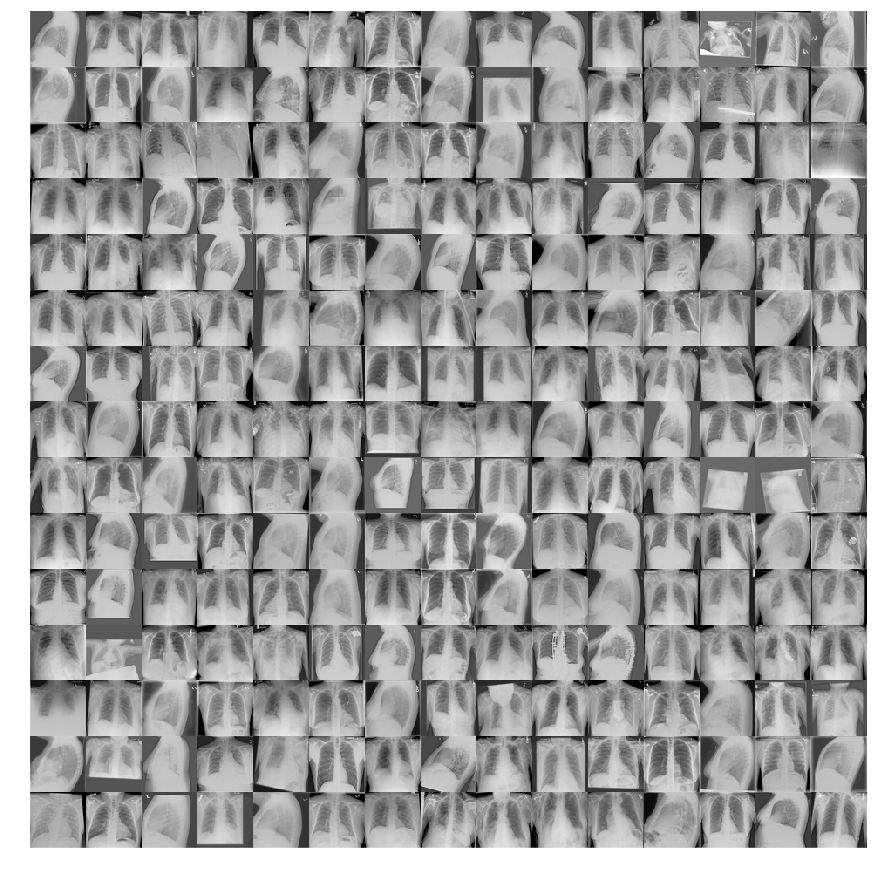

In [17]:
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='Greys_r', interpolation='None')
plt.axis('off')
plt.show()

# Random Images

In [21]:
z = np.random.uniform(-1, 1, (225, args.e_size))
img = draw(z, 15, 15)

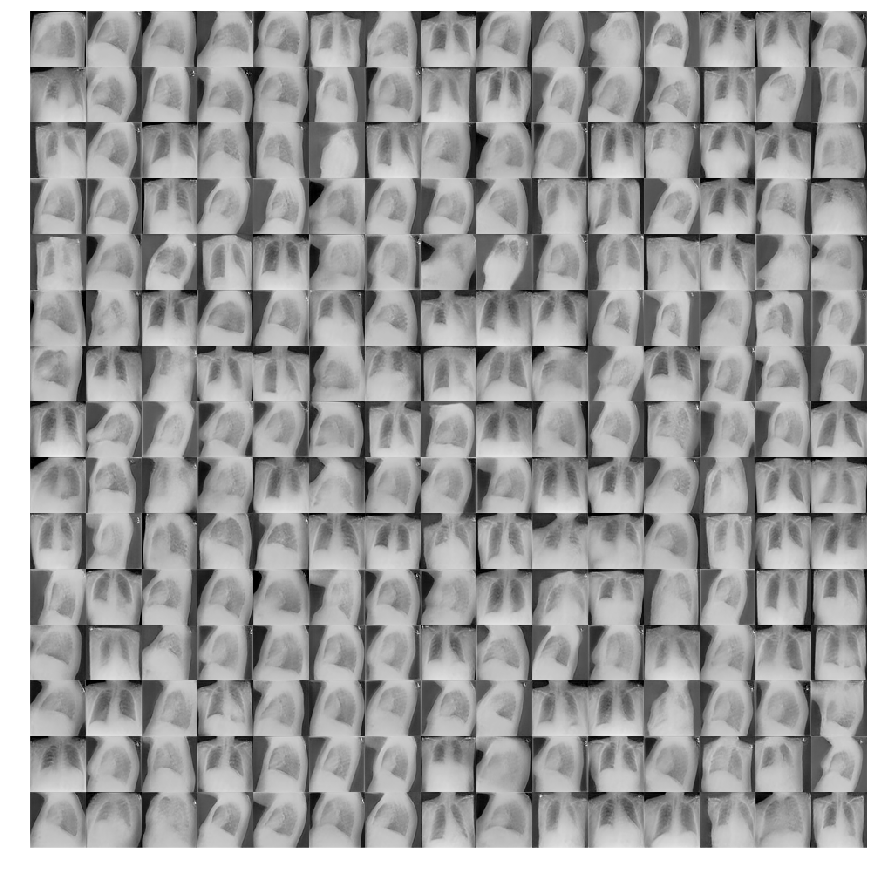

In [22]:
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='Greys_r', interpolation='None')
plt.axis('off')
plt.show()

# Random Interpolation Between 2 Images

In [41]:
img_buf = []
for i in xrange(20):
    t = np.linspace(0, 1, 10).reshape(-1, 1)
    seed1 = np.random.uniform(-1, 1, (1, args.e_size))
    seed2 = np.random.uniform(-1, 1, (1, args.e_size))
    z = t.dot(seed1) + (1 - t).dot(seed2)
    img = draw(z, 1, 10)
    img_buf += [img]
img = np.concatenate(img_buf, axis=0)

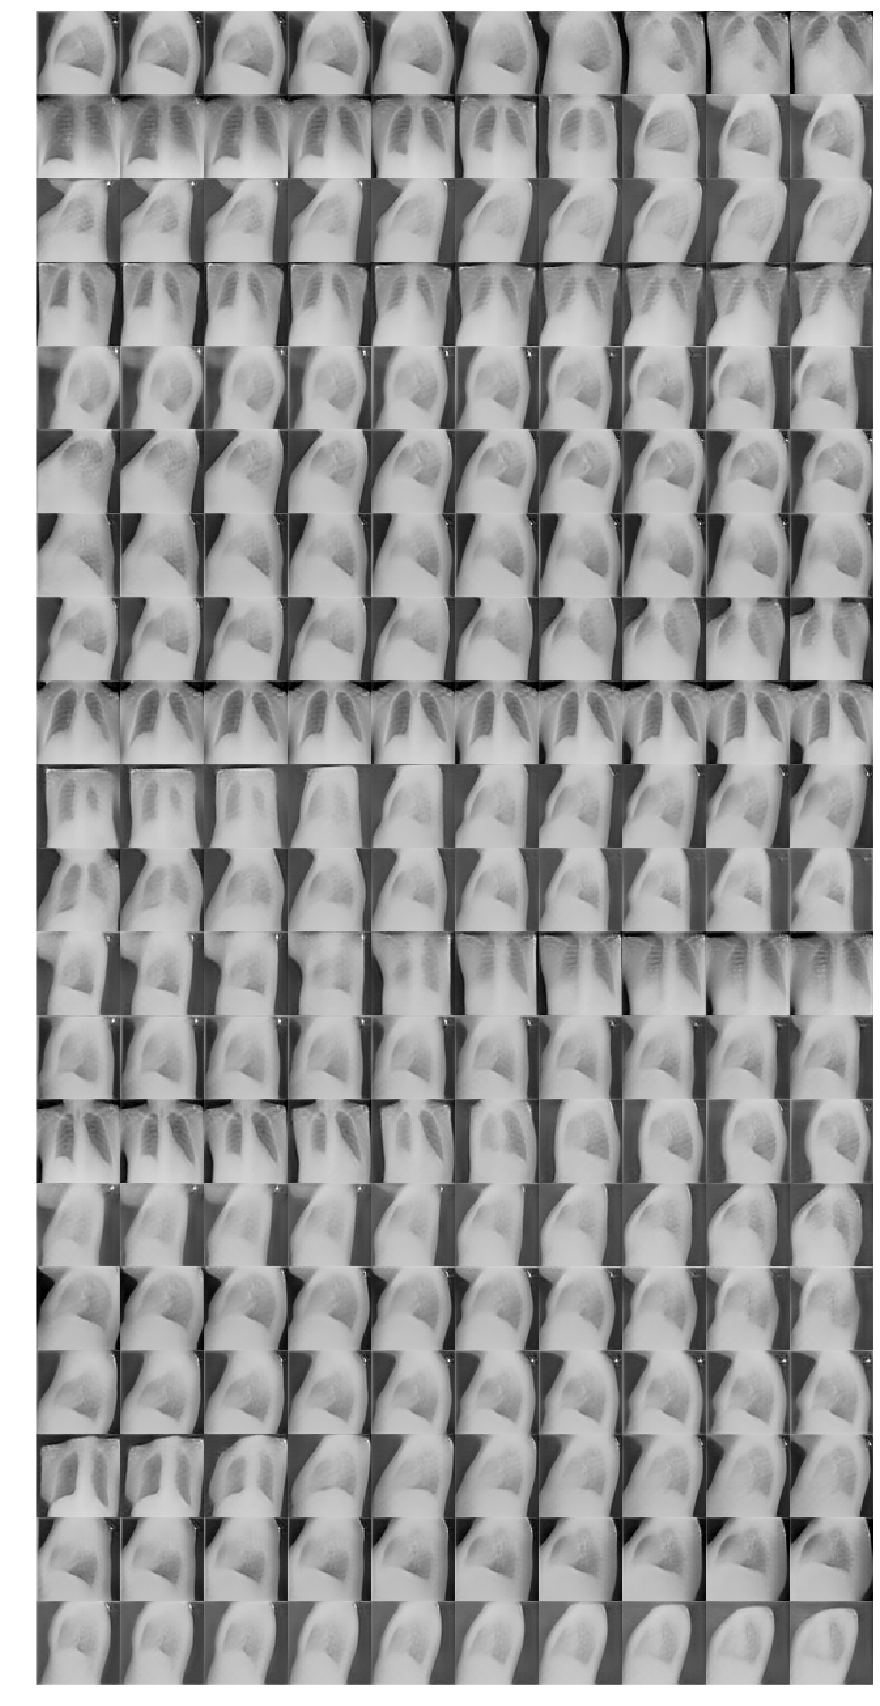

In [42]:
plt.figure(figsize=(20, 30))
plt.imshow(img, cmap='Greys_r', interpolation='None')
plt.axis('off')
plt.show()

# Single Dimension Latent Walk

In [43]:
img_buf = []
for i in xrange(20):
    seed = np.random.uniform(-1, 1, (1, args.e_size))
    z = np.tile(seed, (10, 1))
    z[:, 0] = np.linspace(-1, 1, 10)
    img = draw(z, 1, 10)
    img_buf += [img]
img = np.concatenate(img_buf, axis=0)

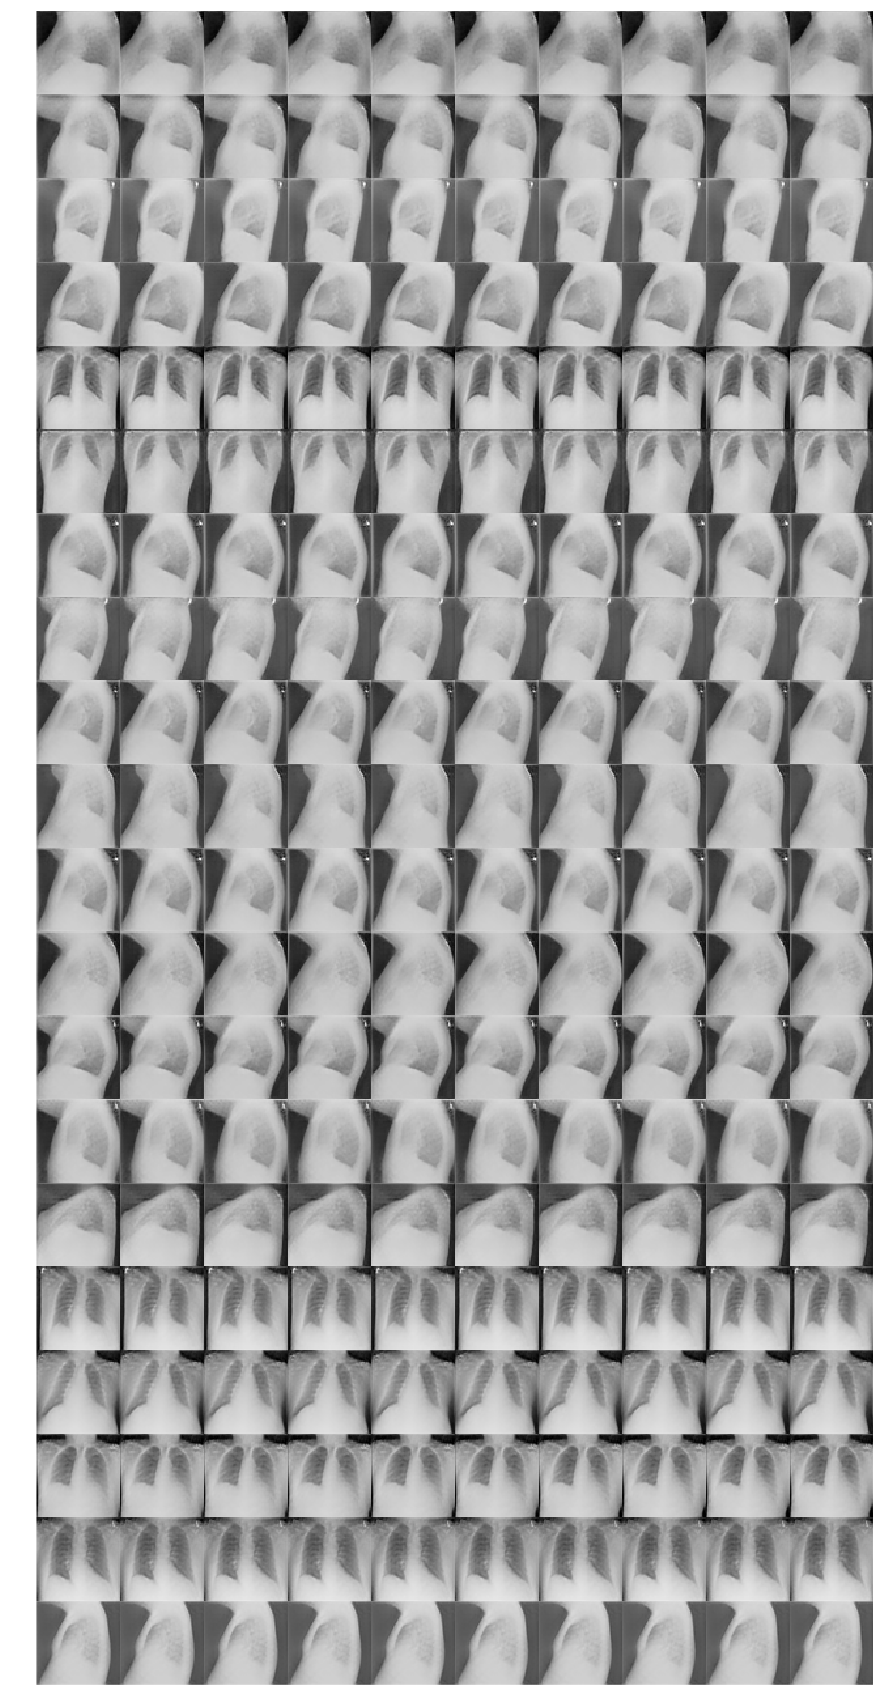

In [44]:
plt.figure(figsize=(20, 30))
plt.imshow(img, cmap='Greys_r', interpolation='None')
plt.axis('off')
plt.show()

# Diagonal Vertex Walk

In [45]:
img_buf = []
for i in xrange(20):
    t = np.linspace(0, 1, 10).reshape(-1, 1)
    seed1 = np.random.choice([-1, 1], (1, args.e_size))
    seed2 = seed1 * -1
    z = t.dot(seed1) + (1 - t).dot(seed2)
    img = draw(z, 1, 10)
    img_buf += [img]
img = np.concatenate(img_buf, axis=0)

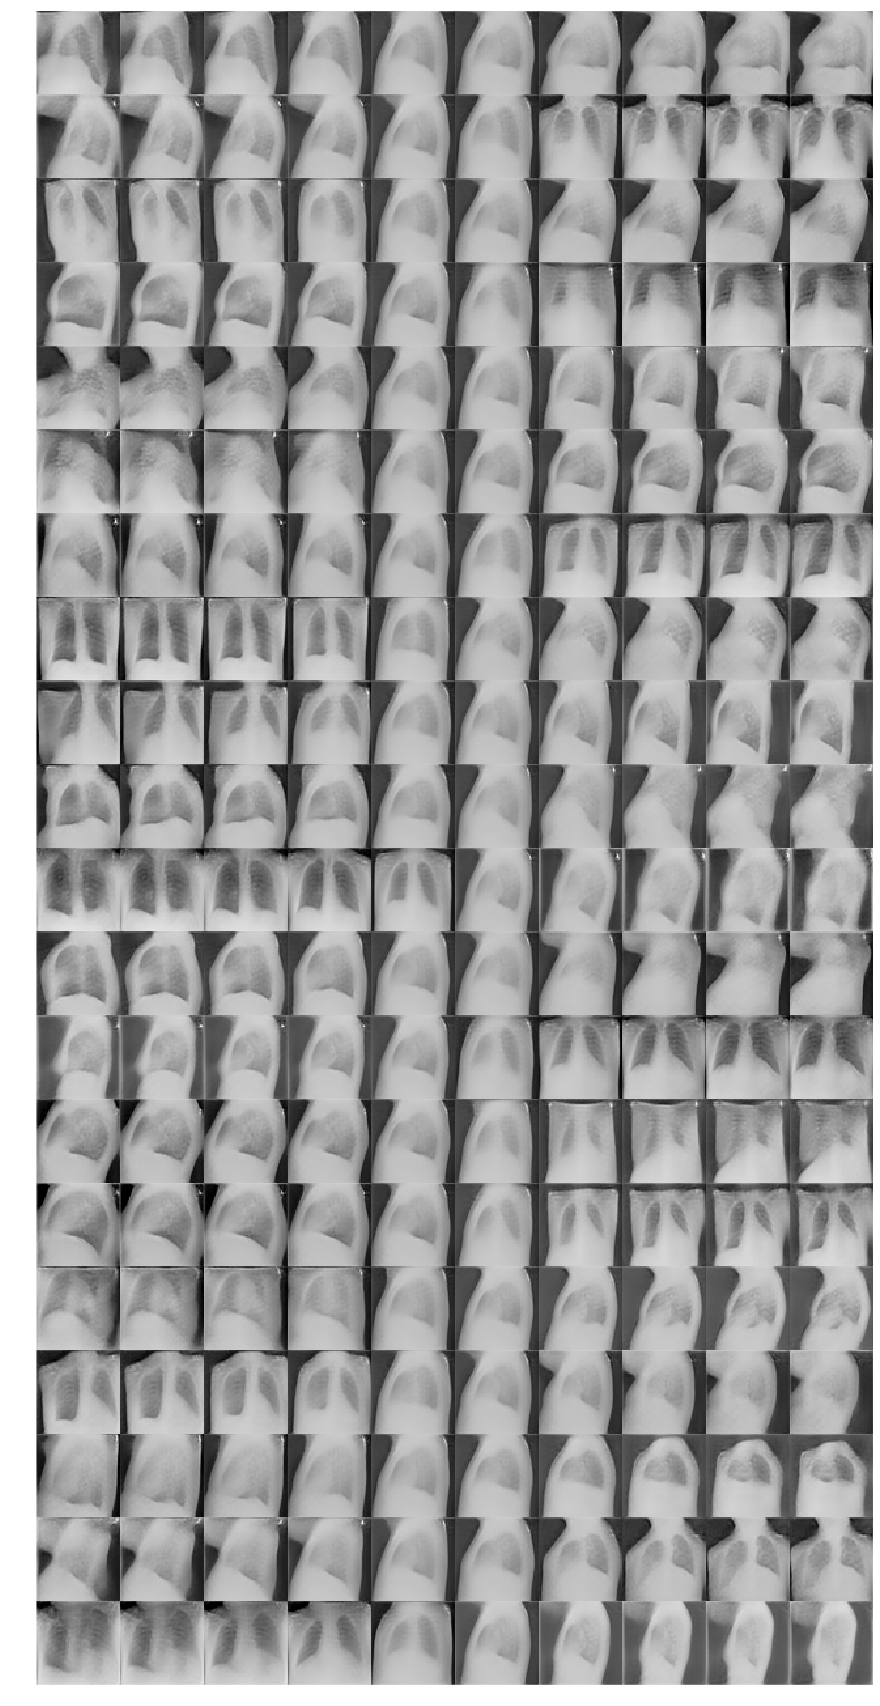

In [46]:
plt.figure(figsize=(20, 30))
plt.imshow(img, cmap='Greys_r', interpolation='None')
plt.axis('off')
plt.show()